In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [4]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596019 entries, 0 to 1596018
Data columns (total 2 columns):
text      1596019 non-null object
target    1596019 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


## Train / Dev / Test Split

In [5]:
x = my_df.text
y = my_df.target

In [7]:
from sklearn.cross_validation import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [8]:
print "Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100)
print "Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100)
print "Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100)

Train set has total 1564098 entries with 50.00% negative, 50.00% positive
Validation set has total 15960 entries with 50.40% negative, 49.60% positive
Test set has total 15961 entries with 50.26% negative, 49.74% positive


In [9]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [14]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print "null accuracy: {0:.2f}%".format(null_accuracy*100)
    print "accuracy score: {0:.2f}%".format(accuracy*100)
    if accuracy > null_accuracy:
        print "model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100)
    elif accuracy == null_accuracy:
        print "model has the same accuracy with the null accuracy"
    else:
        print "model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100)
    print "train and test time: {0:.2f}s".format(train_test_time)
    print "-"*80
    return accuracy, train_test_time

In [15]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print "\n"
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print "Validation result for {} features".format(n)
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

### TFIDF Vectorizer

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [16]:
%%time
print "RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)\n"
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.40%
accuracy score: 81.24%
model is 30.84% more accurate than null accuracy
train and test time: 322.05s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.40%
accuracy score: 81.99%
model is 31.59% more accurate than null accuracy
train and test time: 334.56s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.40%
accuracy score: 82.16%
model is 31.75% more accurate than null accuracy
train and test time: 322.05s
-----------------------------------------------

In [ ]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])

In [17]:
from gensim.models import Doc2Vec

In [15]:
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

In [16]:
model_ug_dbow = Doc2Vec.load('d2v_model_ug_dbow.doc2vec')
model_tg_dmm = Doc2Vec.load('d2v_model_tg_dmm.doc2vec')
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_tg_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [18]:
train_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_train, 200)
validation_vecs_ugdbow_tgdmm = get_concat_vectors(model_ug_dbow,model_tg_dmm, x_validation, 200)

## Dimensionality Reduction

So far, in terms of feature extraction, I have tried three different methods: count vectorizer, Tf-Idf vectorizer, doc2vec. The best validation results I got from each is as below.

Classifier: logistic regression (L2 regularization, regularization strength: 1.0)
- count vectorizer (80,000 features, n-gram range: 1,2,3, stop words removal: X) - 82.44%
- tfidf vectorizer (100,000 features, n-gram range: 1,2,3, stop words removal: X) - 82.92%
- Doc2Vec (unigram DBOW + trigram DMM: total 200 dimension vecotr for each tweet) - 75.76%

And in addition to these, I also have my custom-defined classifier using lexical approach.

- custom lexicon classifier (decision threshold set to 0.56) - 75.96%

Apart from the lexical approach, the number of features needed for the model seems quite big, so I decided to see if I can reduce feature dimensions of Tf-Idf vectorizer and doc2vec vectors. The vectors from Doc2Vec model is of 200 dimensions, sounds quite small compared to 100,000 features of Tf-Idf vectorizer. However, these 200-dimensional vectors are dense matrices with all real numbers, while 100,000 features are sparse matrices with lots of zeros. Thus in terms of computation, Doc2Vec vectors also take a bit of time for computation. So if I can reduce dimensions, then it will be helpful to run various settings of hyperparameter tuning of models.

First, let's try to run dimensionality reduction on Tf-Idf vectors with chi-squared feature selection.

### Chi2 Feature Selection

In Sklearn, there are three methods you can use for feature selection with sparse matrices such as Tfidf vectors or count vectors. By looking at the documentation, you can see that chi2, mutual_info_regression, mutual_info_classif will deal with the data without making it dense. In my case, I have 1.5 million tweets and want to reduce dimensions from 100,000 features, thus transform this into dense matrices is not an option. It will not fit into my RAM.

The Chi-squared statistic measures the lack of independence between a feature (in this case, one term within a tweet) and class (whether the tweets are positive or negative).

You can first think of the relationship between a term within a tweet and the class that the tweet belongs to as in terms of a contingency table. The contingency table is just a fancy word for a table that displays frequency distribution.

Let's say we have three sentences in our corpus as below.
1. I love dogs
2. I hate dogs
3. I love dogs and cooking

And also define the sentiment class of each tweet as positive, negative, positive.

|  | Positive class | Negative class |
|--|--|--|
|"dogs" occur | 2 (A) | 0 (B) |
|"dogs" doesn't occur | 0 (C) | 1 (D) |

Let's define 't' as a specific term we are looking at, in this case, "dogs", and 'c' as the class, since the class only have two classes, it will be either 1 (positive) or 0 (negative). Using contingency table, where A is the number of times 't' occurs and 'c' is positive, B is the number of times 't' occurs and 'c' is negative, C is the number of times 't' doesn't occur and 'c' is positive, finally D is the number of times 't' doesn't occur and 'c' is negative. Now we are ready to calculate Chi-squared statistic.

$${\chi}^2(t,c) = \frac {{N}\times{(AD-CB)}^2}{(A+C)\times(B+D)\times(A+B)\times(C+D)}$$

Where N is the total number of samples, Chi2 score for term "dogs" is 3! Since what chi-square measures is lack of independence between a feature and class if a feature has high chi-squared score compared to other features, it means that the feature is useful to predict the class.

I will first transform the train data into Tfidf vectors of 100,000 features and see which features chi2 has chosen as useful features.

In [19]:
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
x_train_tfidf = tvec.fit_transform(x_train)
x_validation_tfidf = tvec.transform(x_validation)

In [20]:
from sklearn.feature_selection import chi2
chi2score = chi2(x_train_tfidf, y_train)[0]

Let's plot the scores we got on a graph and see which word features are useful for prediction. I will plot only the top 20 features in the below chart, but you can plot as many as you wish as long as your computer screen allows.

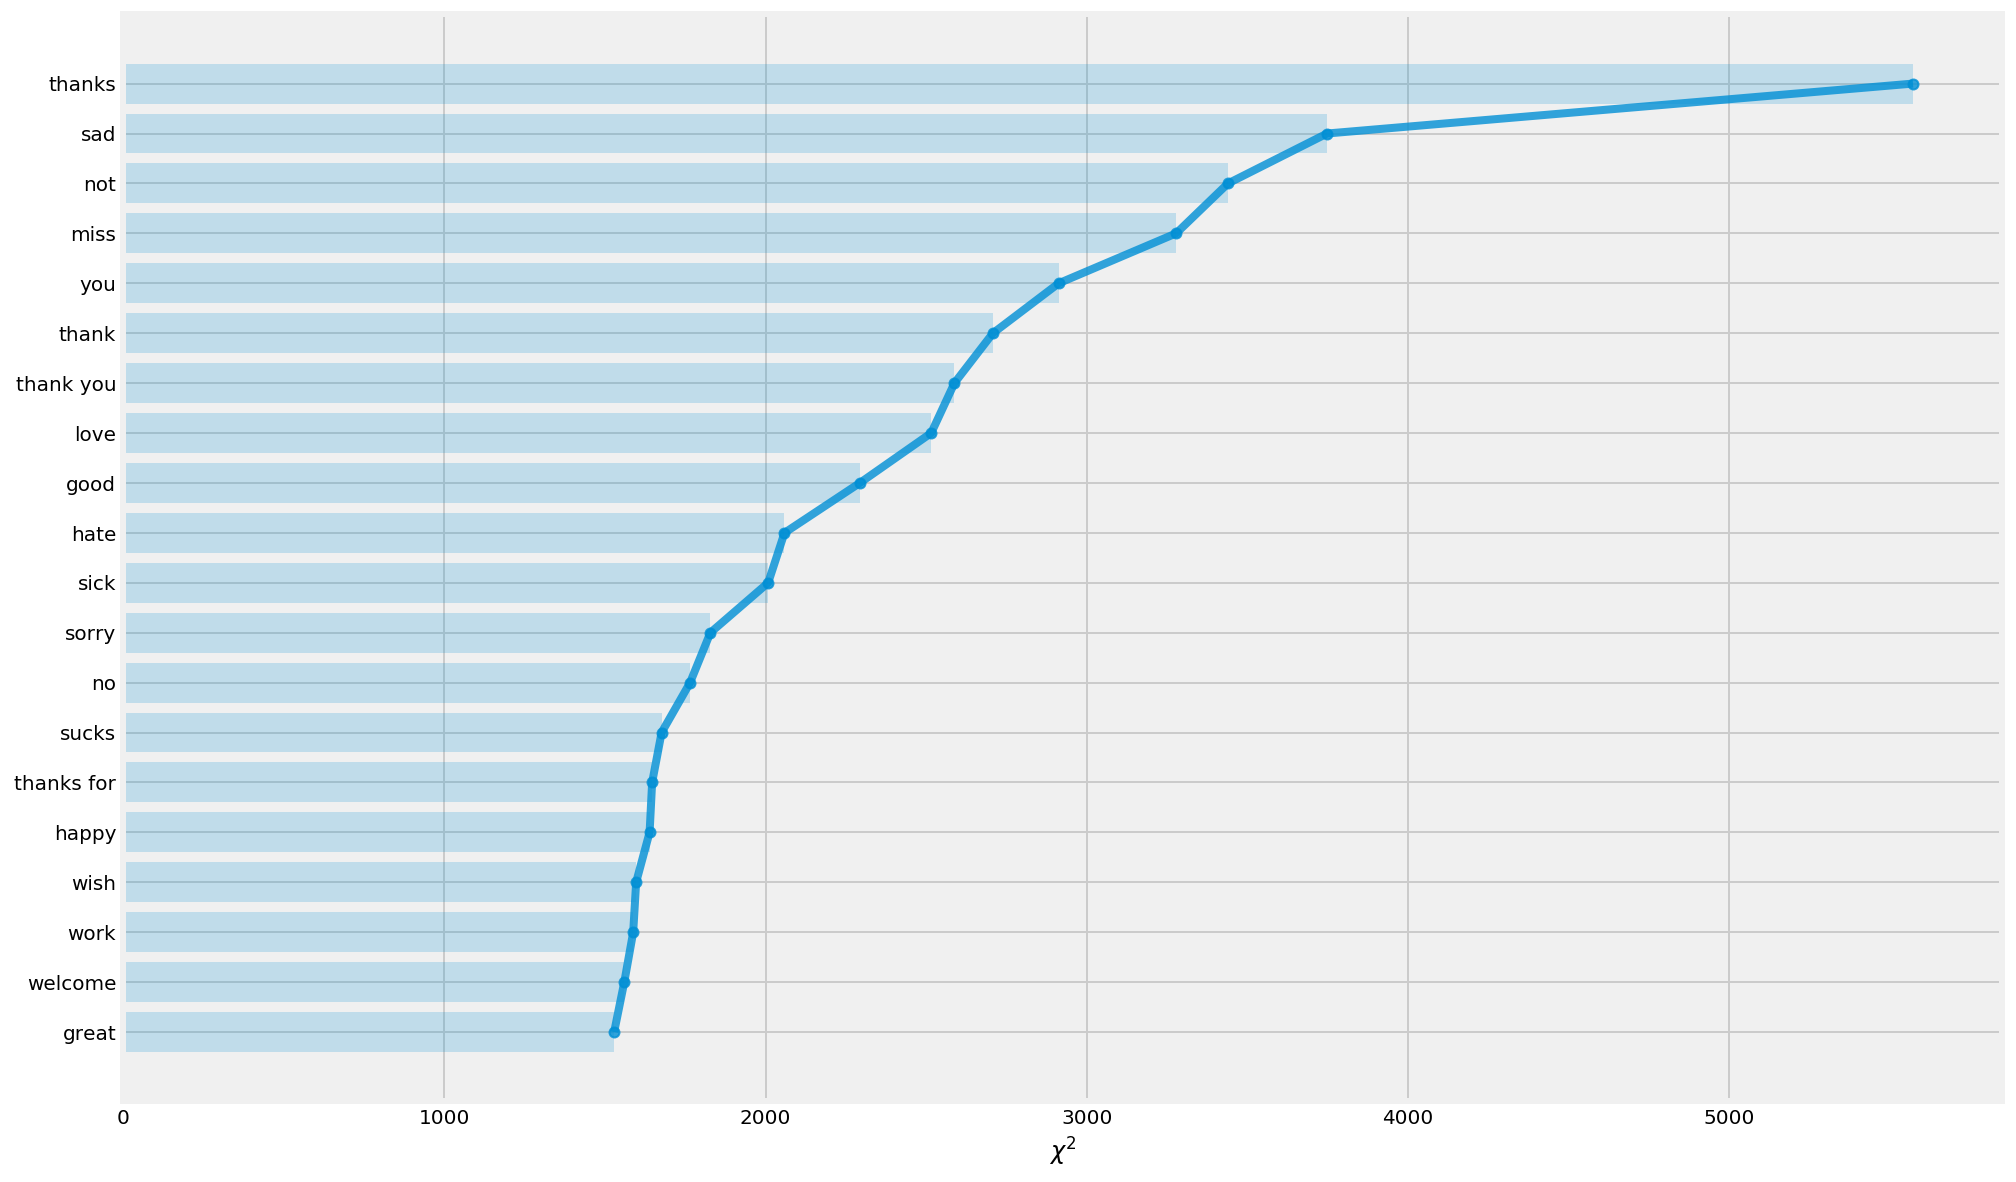

In [23]:
plt.figure(figsize=(15,10))
wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = zip(*wchi2[-20:])
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

The most useful feature selected by chi2 is the word "thanks", and I assume that this came from mostly positive tweets. The second most useful features it chose is the word "sad", and this time I guess it came from negative tweets. If you consider how chi2 is calculated, it will not only score highly on terms predictive of positive class but also score highly on terms predictive of negative class.

Since now we have an idea of how the chi2 feature selection works, let's reduce the dimensions to different number of features, and also check the accuracy on the validation set.

In [83]:
from sklearn.feature_selection import SelectKBest, chi2
ch2_result = []
for n in np.arange(10000,100000,10000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
    x_validation_chi2_selected = ch2.transform(x_validation_tfidf)
    clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_validation)
    ch2_result.append(score)
    print "chi2 feature selection evaluation calculated for {} features".format(n)

chi2 feature selection evaluation calculated for 10000 features
chi2 feature selection evaluation calculated for 20000 features
chi2 feature selection evaluation calculated for 30000 features
chi2 feature selection evaluation calculated for 40000 features
chi2 feature selection evaluation calculated for 50000 features
chi2 feature selection evaluation calculated for 60000 features
chi2 feature selection evaluation calculated for 70000 features
chi2 feature selection evaluation calculated for 80000 features
chi2 feature selection evaluation calculated for 90000 features


One more thing. Tfidf vectorizer can limit the number of features in the first place when you fit and transform the corpus. I want to compare the validation accuracy at the same number of features 1) when the number of features has been limited from Tfidf vectorizing stage, 2) when the number of features has been reduced from 100,000 features using chi2 statistic.

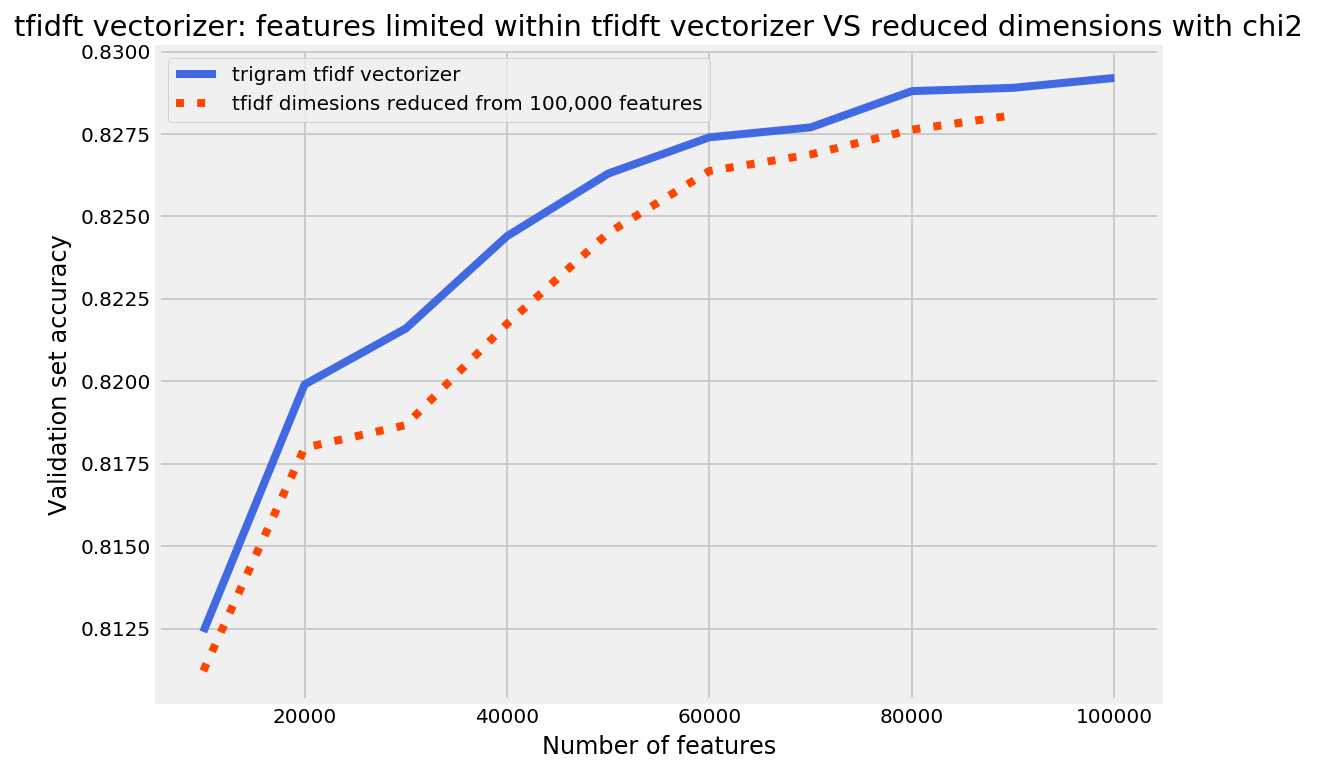

In [85]:
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(np.arange(10000,100000,10000), ch2_result,label='tfidf dimesions reduced from 100,000 features',linestyle=':', color='orangered')

plt.title("tfidft vectorizer: features limited within tfidft vectorizer VS reduced dimensions with chi2")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

On the above graph, the red dotted line is validation set accuracy from dimensionality reduction, and the blue line is the result of limiting the number of features in the first place when fitting Tf-Idf vectorizer. We can see that limiting the number of features in the first place with Tfidf vectorizer yield better result than reducing the dimensions from bigger features. This is not a general statement, but what I have found within this particular setting. If you have a different result with other corpora, I would love to know how it differs.

### Principal Component Analysis (PCA)

PCA is a dimension reduction tool that can be used to reduce a large set of variables to a small set that still contains most of the information in the original set. That sounds cool, you can reduce the features of your data but not retaining the most of the information needed. But if you have tried googling "PCA", you might know that it will give you back the result with all the difficult-sounding terms, such as "Eigenvalue", "Eigenvector", "matrix projection", etc.

In this post, I will not go into too much detail of how PCA is actually calculated but will try to keep it to intuitive level, so that anyone who reads this can understand the underlying concept of it, and implement with Python.

What PCA does is that it transforms the coordinate system so that the axis become the most concise, informative descriptors of our data as a whole.

![title](img_01/PCA_1.png)

Above picture has been borrowed from Meng Xu's blog post on PCA. I found an explanation by Meng Xu really intuitive and helps a lot to understand the concept intuitively. The shape you see in figure (A) is on 3 dimensions, but if we focus on the shape of data, not the axis, the shape itself is flat two-dimension surface. By running PCA, we find new coordinates for the data, which will best describe how the data is shaped. The first Principal Component is one that explains the most variance in the data. In figure (B), we see that by drawing the line "Component 1", it is able to retain the information of the most dispersed points of data. And by adding the line "Component 2", this "Component 2" line explains the second most variance in our data. The next step is to transform the original data onto our new found axis which is just two instead of original three dimensions. The final result in figure (C) gives us a pretty good picture of how the data is shaped only with two dimensions even though we have discarded the third dimension.

http://mengnote.blogspot.co.uk/2013/05/an-intuitive-explanation-of-pca.html

And eigenvectors and eigenvalues are used when implementing this transformation of the data. An eigenvector specifies a direction through the original coordinate space, while eigenvalues indicate the amount of variance in the direction of its corresponding eigenvector.

If you want to dive deeper into the concept of PCA, there are some more blog posts I found useful.
- A blog post by Victor Powell: "Principal Component Analysis" (You can manipulate and play around with data points in 2d or 3d that will help you enormously to have an intuitive understanding of what PCA does)
http://setosa.io/ev/principal-component-analysis/
- A blog post by George Dallas: "Principal Component Analysis 4 Dummies: Eigenvectors, Eigenvalues and Dimension Reduction" (he has successfully explained the concept without a single math formula, unbelievable)
https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/

Next, let's try to reduce dimensions of doc2vec vectors with PCA. We can also plot the result on a graph and see if it's feasible to reduce the number of features with a smaller set of principal components, and how much of the variance given number of principal components can explain about the original features.

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
d2v_ugdbow_tgdmm_std = scaler.fit_transform(train_vecs_ugdbow_tgdmm)
d2v_ugdbow_tgdmm_std_val = scaler.fit_transform(validation_vecs_ugdbow_tgdmm)

In [39]:
from sklearn.decomposition import PCA

d2v_pca = PCA().fit(d2v_ugdbow_tgdmm_std)

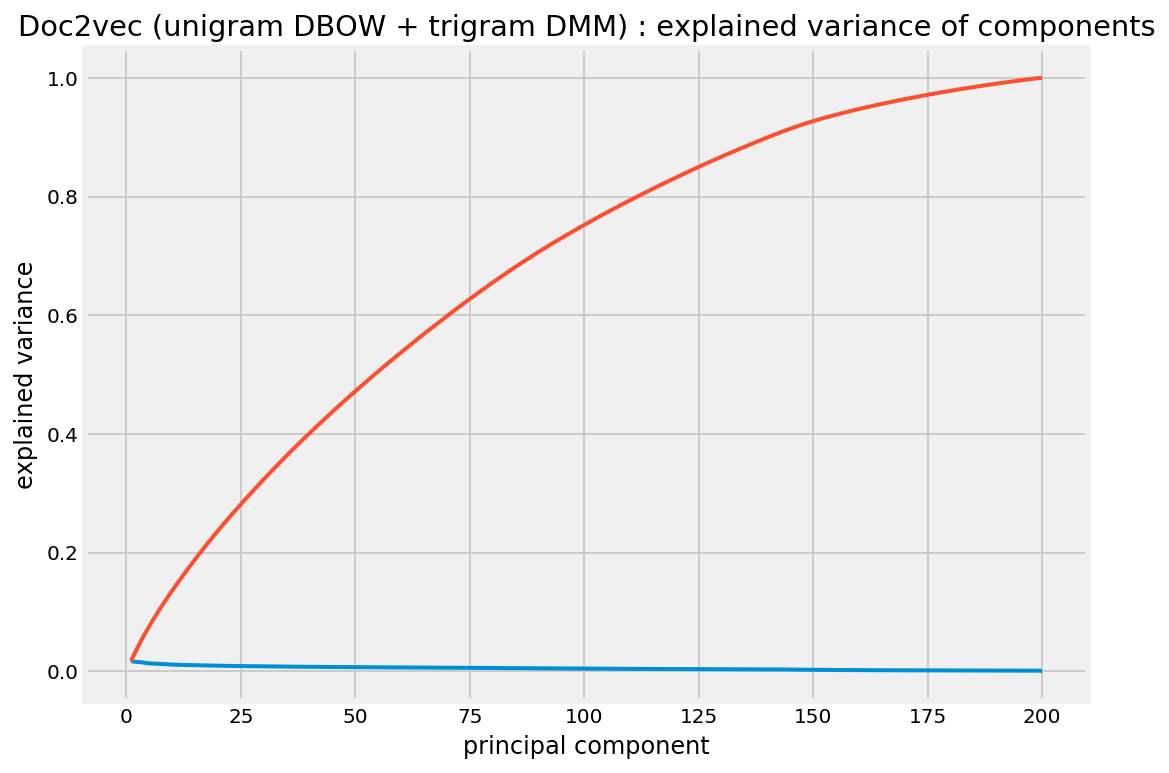

In [40]:
fig, ax = plt.subplots(figsize=(8,6))

x_values = range(1, d2v_pca.n_components_+1)

ax.plot(x_values, d2v_pca.explained_variance_ratio_, lw=2, label='explained variance')
ax.plot(x_values, np.cumsum(d2v_pca.explained_variance_ratio_), lw=2, label='cumulative explained variance')
ax.set_title('Doc2vec (unigram DBOW + trigram DMM) : explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

In the above graph, the red line represents cumulative explained variance and the blue line represents explained the variance of each principal component. By looking at the graph above, even though the red line is not perfectly linear, but very close to a straight line. Is this good? No. This means each of the principal components contributes to the variance explanation almost equally, and there's not much point in reducing the dimensions based on PCA. This can also be seen from the blue line, which is very close to a straight line in the bottom.

It is a bit disappointing, that in my specific case with tweets text data, dimensionality reduction is not very helpful. Tf-Idf vectors showed a better result when the features are limited with Tfidf vectorizer in the first place than to reduce dimension afterwards, and doc2vec vectors seem to carry the roughly similar amount of information through its 200 dimension feature space.

Again this is not a general statement, this is just what I found out with my particular data. And especially with PCA, when it is applied to numerical features, I saw it successfully reduce the dimension of the data from 100 or more features to around 10 features while being able to explain 90% of the data variance.